# Bayes PRF using pymc
Load eg data + design matrix

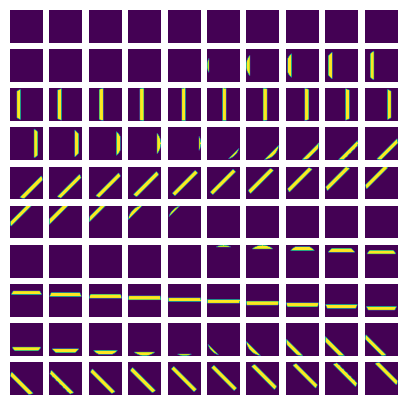

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
try:
    from prfpy_csenf.stimulus import PRFStimulus2D
    from prfpy_csenf.model import Iso2DGaussianModel, Norm_Iso2DGaussianModel
except:
    from prfpy.stimulus import PRFStimulus2D
    from prfpy.model import Iso2DGaussianModel, Norm_Iso2DGaussianModel
from datetime import datetime
from prfpy_bayes.utils import *

# If you already have the design matrix as a numpy array, you can simply load it...
dm = np.load('./design_matrix.npy')

# You can see we have a binarized matrix, of a bar moving across the screen...
fig = plt.figure()
rows = 10
cols = 10
fig.set_size_inches(5,5)
for i in range(100):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(dm[:,:,i], vmin=0, vmax=1)
    ax.axis('off')
# Now we need to enter the design matrix in a way that prfpy can read it. 
prf_stim = PRFStimulus2D(
    screen_size_cm=39.3,          # Distance of screen to eye
    screen_distance_cm=196,  # height of the screen (i.e., the diameter of the stimulated region)
    design_matrix=dm,                                   # dm (npix x npix x time_points)
    TR=1.5,                                  # TR
    )
# Now we can make the model
g_model = Iso2DGaussianModel(stimulus=prf_stim, hrf=[1, 4.6, 0], normalize_RFs=True)
#dn_model = Norm_Iso2DGaussianModel(stimulus=prf_stim, hrf=[1, 4.6, 0])

# Data
psc_runs = np.load('eg_data.npy')

# Using PYMC as a black box...
Why do this? Not necessarily the most efficient; but it means you don't have to redefine everything

https://www.pymc.io/projects/examples/en/latest/howto/blackbox_external_likelihood_numpy.html


In [ ]:
import pytensor

import pytensor.tensor as pt

from pytensor.graph import Apply, Op
from scipy.optimize import approx_fprime
import scipy.stats
cdf = scipy.stats.norm.cdf

pytensor.config.optimizer = 'None'
# pytensor.config.exception_verbosity = 'high'
pytensor.config.linker = 'py'
def my_model(l_ecc, l_pol, l_size, l_beta):
    """"""
    radius = 5
    min_size = 0.5

    ecc = radius * cdf(l_ecc, 0, 1)
    pol = 2*np.pi*cdf(l_pol, 0, 1) - np.pi
    x = ecc*np.cos(pol)
    y = ecc*np.sin(pol)
    size = min_size + (radius-min_size)*cdf(l_size)
    beta = np.exp(l_beta)
    return g_model.return_prediction(
        mu_x = x,
        mu_y = y,
        size = size,
        beta = beta,
        baseline = np.array([0])
    ).squeeze()

def my_loglike(l_ecc, l_pol, l_size, l_beta, data):
    """"""
    radius = 5
    min_size = 0.5
    noise_sd = 1
    ecc = radius * cdf(l_ecc, 0, 1)
    pol = 2*np.pi*cdf(l_pol, 0, 1) - np.pi
    x = ecc*np.cos(pol)
    y = ecc*np.sin(pol)
    size = min_size + (radius-min_size)*cdf(l_size)
    beta = np.exp(l_beta)
    pred = g_model.return_prediction(
        mu_x = x,
        mu_y = y,
        size = size,
        beta = beta,
        baseline = np.array([0])
    ).squeeze()
    residuals = data - pred
    log_like = -0.5 * (np.log(2*np.pi*noise_sd**2) + (residuals/noise_sd)**2)
    
    return log_like.astype(np.float32)

class LogLike(Op):
    def make_node(self, l_ecc, l_pol, l_size, l_beta, data
                  ) -> Apply:
        l_ecc = pt.as_tensor(l_ecc)
        l_pol = pt.as_tensor(l_pol)
        l_size = pt.as_tensor(l_size)
        l_beta = pt.as_tensor(l_beta)
        data = pt.as_tensor(data)

        inputs = [l_ecc, l_pol, l_size, l_beta, data]
        # Define output type, in our case a vector of likelihoods
        # with the same dimensions and same data type as data
        # If data must always be a vector, we could have hard-coded
        # outputs = [pt.vector()]
        outputs = [data.type()]

        # Apply is an object that combines inputs, outputs and an Op (self)
        return Apply(self, inputs, outputs)

    def perform(self, node: Apply, inputs: list[np.ndarray], outputs: list[list[None]]) -> None:
        # This is the method that compute numerical output
        # given numerical inputs. Everything here is numpy arrays
        l_ecc, l_pol, l_size, l_beta, data = inputs

        # call our numpy log-likelihood function
        loglike_eval = my_loglike(l_ecc, l_pol, l_size, l_beta, data)
        # Save the result in the outputs list provided by PyTensor
        # There is one list per output, each containing another list
        # pre-populated with a `None` where the result should be saved.
        outputs[0][0] = loglike_eval #np.asarray(loglike_eval)

# Create a Op object
loglike_op = LogLike()
test_out = loglike_op(
    np.array([0]),
    np.array([0]),
    np.array([0]),
    np.array([0]), 
    psc_runs[0,:])

pytensor.dprint(test_out)
# os.environ['']
test_out.eval()
my_loglike(0, 0, 0, 0, psc_runs[0,:])

In [ ]:
def custom_dist_loglike(data, l_ecc, l_pol, l_size, l_beta):
    # data, or observed is always passed as the first input of CustomDist
    return loglike_op(l_ecc, l_pol, l_size, l_beta, data)

import pymc as pm
# use PyMC to sampler from log-likelihood
data = psc_runs[0,:].squeeze().copy()
with pm.Model() as no_grad_model:
    # Priors
    l_ecc = pm.Normal("l_ecc", mu=0, sigma=1, initval=0)
    l_pol = pm.Normal("l_pol", mu=0, sigma=1, initval=0)
    l_size = pm.Normal("l_size", mu=0, sigma=1, initval=.1)
    l_beta = pm.Normal("l_beta", mu=-2, sigma=5, initval=-1)    

    # use a CustomDist with a custom logp function
    likelihood = pm.CustomDist(
        "likelihood", 
        l_ecc, l_pol, l_size, l_beta,
        observed=data,
        logp=custom_dist_loglike,
    )
    ip = no_grad_model.initial_point()
    

In [ ]:

ip

In [ ]:
np.random.seed(0)
radius = 5
min_size = .1

observed_data = psc_runs[0,:].squeeze()
with pm.Model() as model:
    # Priors on latent parameters
    l_ecc = pm.Normal('l_ecc', mu=0, sigma=1)
    l_pol = pm.Normal('l_pol', mu=0, sigma=1)
    l_size = pm.Normal('l_size', mu=0, sigma=1)
    l_beta = pm.Normal('l_beta', mu=-2, sigma=5)
    noise_sd = pm.HalfNormal('noise_sd', sigma=1)

    logl = LogLikeGauss(
        data=psc_runs[0,:].squeeze(),        
    )

    # conver to a tensor vector
    theta = pt.as_tensor_variable([l_ecc, l_pol, l_size, l_beta, noise_sd])

    # Use potential to "call" the Op 
    # and include it in the logp computation
    pm.Potential('likelihood', logl(theta))

    # Use custom number of draws to replace the HMC default
    idata_mh = pm.sample(100, tune=10, step=pm.Slice())
        






In [38]:
import scipy


In [ ]:
g_model.return_prediction(
            mu_x = 0,
            mu_y = 0,
            size = 3,
            
            beta = 1,
            baseline = 0,   
        )
        

In [ ]:
pm.math.er

In [ ]:
np.

In [ ]:
g_model.return_prediction

In [ ]:
from prfpy_bayes.prf_bayes import *
# Start by making the bprf objects
Gbprf = BayesPRF(
    prf_params=None, # We could put in our best guess here, but we will let the model figure it out...
    model = 'gauss',
    prfpy_model=g_model,
    real_ts=psc_runs,
    beta_method='glm', # We are going to use the glm method to estimate the betas (not inside the MCMC)
    fixed_baseline=0, # We are not going to fit the baseline
    )
bounds = {
    'x': [-5, 5],
    'y': [-5, 5],
    'size_1': [0.1, 10],
    'amp_1': [1, 1],
    'bold_baseline': [0, 0],
    'hrf_deriv' : [0, 10],
    'hrf_disp' : [0, 10],
}
# Uniform prior, based on bounds 
Gbprf.add_priors_from_bounds(bounds)
# Get everything ready...
Gbprf.prep_info()

# Let start with a single voxel
initial_guess = [
    0, # x
    0, # y
    1, # size
    # 1, # amplitude
    4.6, # hrf_disp
    0, # hrf_deriv
]
# which timeseries to fit
idx = 0

# Use the multiprocessing pool -> to speed things up
import multiprocessing
# Quick check, how many cpus do we have?
print(f"Number of cpus: {multiprocessing.cpu_count()}")
n_cpus = 14 # I'm using 14 for speeeed!

idx = 0 # Index of the vertex times series to fit
n_steps = 50
n_walkers = 20
time_start = datetime.now()
with multiprocessing.Pool(n_cpus) as pool:
    # We need to set the model for the global model object
    # this is because parallel processing does not allow for the model to be pickled
    # If it doesn't work the first time, try again... 
    # for some reason this is not always working the first time...

    prfpy_global_model.set_model(g_model)
    Gbprf.run_mcmc_fit(
        initial_guess=initial_guess,
        idx=idx, 
        n_walkers=20,
        n_steps=4000, 
        pool=pool, 
        eps=.1,
        # What to save? 
        # we fit alot of stuff...
        # burn_in=500,        # Remove the first n steps as burn in 
        save_top_kpsc=None,   # Save the top k% of fits? [None for all] 
        save_min_rsq=None,     # Minimum rsq to save?  [None for all]
        save_mode='obj',    # Save mode (obj or minimal). Obj saves the whole object, minimal just the parameters        


    )
time_end = datetime.now()
print(f"Time taken: {time_end - time_start}")    

In [ ]:
# Lets plot our samples around the visual field 
Gbprf.sampler[idx].visual_field(
    dot_col='rsq',      # Color by r squared
    th={'min-step_id':250},              # No threshold
    do_colbar=True,
    dot_vmin=0,    dot_vmax=1,   
    dot_size=10,
)

In [ ]:
print(Gbprf.sampler[idx].pd_params.rsq.argmax())
Gbprf.sampler[idx].prf_ts_plot(71532)

In [ ]:
# Can we use this to look at some of the correlation structure in the parameters?
# -> i.e. which parameters can trade off against each other?
burn_in = 500

# For example size and amplitude
Gbprf.sampler[idx].scatter(
    px='size_1', py='amp_1',pc='rsq',
    vmin=0,vmax=1, 
    th={
        'min-step_id' : burn_in, # Only include samples after burn in time point. 
        'min-rsq' : 0, # Only rsq > 0
    },
    do_colbar=True, 
    do_corr=True, 
)

# What about size and hrf_deriv?
plt.figure()
Gbprf.sampler[idx].scatter(
    px='size_1', py='hrf_deriv',pc='rsq',
    vmin=0,vmax=1, 
    th={
        'min-step_id' : burn_in, # Only include samples after burn in time point. 
        'min-rsq' : 0, # Only rsq > 0
    },
    do_colbar=True, 
    do_corr=True, 
)

# What about size and hrf_disp?
plt.figure()
Gbprf.sampler[idx].scatter(
    px='hrf_disp', py='hrf_deriv',pc='rsq',
    vmin=0,vmax=1, 
    th={
        'min-step_id' : burn_in, # Only include samples after burn in time point. 
        'min-rsq' : 0, # Only rsq > 0
    },
    do_colbar=True, 
    do_corr=True, 
)


In [ ]:
# Ok that was interesting. 
# Lets look at some time series! Ideally where parameters differ, so we can see this tradeoff type thing
good_fits = np.where(Gbprf.sampler[idx].pd_params['rsq'] > 0.3)[0]
plot_eg = 0
size_previous = -100
for i in good_fits:
    size_current = Gbprf.sampler[idx].pd_params['size_1'][i]
    if np.abs(size_current - size_previous) < 0.2:
        continue
    else:
        # Plot it if the size is different enough!!
        size_previous = size_current
        _ = Gbprf.sampler[idx].prf_ts_plot(i)
        plot_eg += 1
    if plot_eg > 5:
        break
        
    

# DN - same again but with the divisive normalisation model!

In [ ]:
# Fake some data
fake_params = np.array([ -1, -1,  1.36,  4.8, 0,  .4,  3.42,  0.2,
        3.16,  4.6,  0])
fake_ts = dn_model.return_prediction(
    *list(fake_params),
    )
plt.plot(fake_ts.T)

In [ ]:
from pfa_scripts.load_saved_info import *
from dag_prf_utils.prfpy_ts_plotter import TSPlotter

psc = load_data_tc('sub-01', 'AS0', )['AS0']
prfpy_stim = get_prfpy_stim('sub-01', 'AS0')['AS0']
dn_model = Norm_Iso2DGaussianModel(stimulus=prfpy_stim, hrf=[1, 4.6, 0])
prf = TSPlotter(
    load_data_prf('sub-01', 'AS0', 'norm')['AS0']['norm'],
    model='norm',
    real_ts=psc,
    prfpy_model=dn_model,
)

In [ ]:
vx_mask = prf.return_vx_mask({
    'min-rsq':.1, 
    'min-size_1':0.1,
    'min-b_val' : 200, 
}    
)
print(np.where(vx_mask)[0])

In [ ]:
prf.prf_ts_plot(542745)


In [ ]:
from prfpy_bayes.prf_bayes import BayesPRF
# Start by making the bprf objects
Nbprf = BayesPRF(
    prf_params=prf.prf_params_np, # We could put in our best guess here, but we will let the model figure it out...
    model = 'norm',
    prfpy_model=dn_model,
    real_ts=psc, #psc_runs,
    beta_method='glm',
    fixed_baseline=0, 
    )
Nbounds = {
    'x': [-5, 5],
    'y': [-5, 5],
    'size_1': [0.1, 10],
    'amp_1': [0, 10],
    'size_2' : [0.1, 10],
    'amp_2' : [0, 10],
    'b_val' : [0, 10],
    'd_val' : [0, 10],
    'bold_baseline': [0, 0],
    'hrf_deriv' : [1, 1], # Not going to fit the HRF, we have enough to deal with...
    'hrf_disp' : [0, 0],
}

Nbprf.add_priors_from_bounds(Nbounds)
Nbprf.prep_info()
print(Nbprf.init_p_id)

In [ ]:
idx = 542745
initial_guess = [
    0, # x
    0, # y
    1, # size
    # 1, # amp_1
    .1, # amp_2
    1, # size_2
    1, # b_val
    10, # d_val
]
time_start = datetime.now()
with multiprocessing.Pool(n_cpus) as pool:
    # We need to set the model for the global model object
    # this is because parallel processing does not allow for the model to be pickled
    # If it doesn't work the first time, try again... 
    # for some reason this is not always working the first time...

    prfpy_global_model.set_model(dn_model)
    Nbprf.run_mcmc_fit(
        # initial_guess=initial_guess,
        idx=idx, 
        n_walkers=40,
        n_steps=1000, 
        pool=pool, 
        eps=1,
        # What to save?
        # we fit alot of stuff...
        # burn_in=500,        # Remove the first n steps as burn in
        save_top_kpsc=None,   # Save the top k% of fits? [None for all]
        save_min_rsq=None,     # Minimum rsq to save?  [None for all]
        save_mode='obj',    # Save mode (obj or minimal). Obj saves the whole object, minimal just the parameters
        enforce_bounds=True, # Enforce the bounds
    )
time_end = datetime.now()
print(f"Time taken: {time_end - time_start}")

In [147]:
mprf = Nbprf.sampler[idx]

In [ ]:
print(mprf.pd_params.rsq.argmax())
_ = mprf.prf_ts_plot(16)
_ = prf.prf_ts_plot(idx)

In [ ]:
Nbprf.sampler[idx].visual_field(
    dot_col='rsq', 
    th={}, #{'min-step_id':250},
    # th={'min-rsq':.1, }, #'min-step_id':500},
    do_colbar=True,
    # dot_vmin=0, 
    dot_size=10,
)

In [ ]:
Nbprf.sampler[idx].pd_params.rsq.max()
# Nbprf.sampler[idx].prf_params_np[36016,:]



In [ ]:
Nbprf.sampler[idx].pd_params

In [ ]:
vx_mask = np.ones_like(Nbprf.sampler[idx].pd_params.rsq)
print(Nbprf.sampler[idx].pd_params.rsq.argmax())
vx_mask[Nbprf.sampler[idx].pd_params.rsq < 0.7] = 0
# vx_mask[Nbprf.sampler[idx].pd_params.amp_1 < 0] = 0
vx_mask[Nbprf.sampler[idx].pd_params.size_1 > Nbprf.sampler[idx].pd_params.size_2] = 0

id2see = np.where(vx_mask)[0]
old_size2 = -100
for i in id2see[:2400]:
    size2 = Nbprf.sampler[idx].pd_params.size_2[i]
    if np.abs(size2 - old_size2) < 2:
        continue
    else:
        _ = Nbprf.sampler[idx].prf_ts_plot(i)
        old_size2 = size2


In [ ]:
id2see.shape

In [ ]:
Nbprf.sampler[idx].prf_ts_plot(11054)

In [ ]:
# Multiple scatter for several parameters 
Nbprf.sampler[idx].multi_scatter(
    ['size_1', 'size_2','b_val', 'd_val', 'rsq'],
    th={'min-rsq':0,}, # 'min-size_ratio':1}, 
    # th={'min-rsq':0.76, 'min-step_id':500, 'min-b_val':0},
    # do_id_line=True, 
    do_line=True, 
    dag_scatter=True, 
    
)
plt.gcf().set_size_inches(10,10)

In [ ]:
print()

In [ ]:
np.percentile(Nbprf.sampler[idx].pd_params.rsq, 85)